In [1]:
import sys
sys.path.append("../")
sys.path.append("../fastai/")

In [2]:
%load_ext watermark
%watermark -p torch,pandas,numpy -m

torch 0.4.1
pandas 0.22.0
numpy 1.15.0

compiler   : GCC 7.2.0
system     : Linux
release    : 4.10.0-32-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
from pathlib import Path
import itertools
from collections import Counter
from functools import partial, reduce

import joblib
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import precision_recall_fscore_support
from fastai.text import (
    SortishSampler, SortSampler, DataLoader, ModelData, to_gpu
)
from fastai.core import T
from fastai.rnn_reg import EmbeddingDropout
from fastai.text import accuracy
from torch.optim import Adam
import torch.nn as nn
import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import sentencepiece as spm

from cnlp.fastai_extended import (
    LanguageModelLoader, LanguageModelData, get_transformer_classifier, 
    TransformerTextModel, TextDataset, TransformerLearner, FixedLengthDataLoader,
    ShuffledLanguageModelLoader
)

%matplotlib inline

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


In [4]:
path = Path("../data/cache/lm_unigram_transformer_douban/")
path.mkdir(parents=True, exist_ok=True)

## Utility Function(s)

In [5]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Import And Tokenize Comments and Ratings

In [6]:
df_ratings = pd.read_csv("../data/ratings_word.csv")
df_ratings.head()

,comment,rating
0,别 拿 矫揉造作 的 资产阶级 情调 麻醉 中国 人民 ！,1
1,文青 们 向往 的 生活 ， 可是 生活 中 没有 了 喜怒哀乐 ， 没有 了 问题 与 冲...,2
2,自由 也许 在 大理 ， 生活 确实 在 别处 。,3
3,原来 八旬 是 小四 的 老公 ， 小 彩旗 的 爹 ， 杨丽萍 的 妹夫 。,3
4,关于 大理 的 蓝光 旅游 宣传片 。,3


In [7]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=888)
train_idx, test_idx = next(sss.split(df_ratings, df_ratings.rating))
df_train = df_ratings.iloc[train_idx].copy()
df_test = df_ratings.iloc[test_idx].copy()
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=888)
val_idx, test_idx = next(sss.split(df_test, df_test.rating))
df_val = df_test.iloc[val_idx].copy()
df_test = df_test.iloc[test_idx].copy()
del df_ratings

In [8]:
UNK = 0
BEG = 1
EMB_DIM = 480

In [9]:
sp = spm.SentencePieceProcessor()
sp.Load("../data/rating_unigram_model.model")

True

### Use the Refitted Vocabulary
#### Investigate Vocabulary Differences

In [19]:
itos_orig = []
with open("../data/unigram_model.vocab", mode="r", encoding="utf-8") as f:
    for line in f.readlines():
        itos_orig.append(line.split("\t")[0])
itos = []
with open("../data/rating_unigram_model.vocab", mode="r", encoding="utf-8") as f:
    for line in f.readlines():
        itos.append(line.split("\t")[0])
n_toks = len(itos)
n_toks

7500

In [10]:
itos[:5]

['<unk>', '<s>', '</s>', '▁,', '▁的']

In [25]:
mapping = {s: idx for idx, s in enumerate(itos)}
mapping_orig = {s: idx for idx, s in enumerate(itos_orig)}

In [26]:
voc_diff = set(itos) - set(itos_orig)
print(len(voc_diff), len(itos))
sorted([(x, mapping[x]) for x in list(voc_diff)], key=lambda x: x[1], reverse=True)[:50]

2823 7500


[('婪', 7499),
 ('★', 7491),
 ('】', 7490),
 ('兀', 7489),
 ('☆', 7488),
 ('葩', 7487),
 ('̄', 7486),
 ('喂', 7485),
 ('咱', 7484),
 ('匆', 7482),
 ('蝴', 7478),
 ('袱', 7477),
 ('寥', 7476),
 ('疙', 7475),
 ('痨', 7474),
 ('【', 7470),
 (']', 7469),
 ('*', 7468),
 ('扔', 7466),
 ('窒', 7464),
 ('漓', 7462),
 ('肮', 7459),
 ('@', 7458),
 ('[', 7457),
 ('驭', 7455),
 ('渲', 7453),
 ('樟', 7452),
 ('跪', 7451),
 ('甩', 7448),
 ('噱', 7445),
 ('暧', 7440),
 ('谑', 7439),
 ('蹩', 7435),
 ('讶', 7434),
 ('戛', 7431),
 ('╭', 7428),
 ('娴', 7423),
 ('蹋', 7422),
 ('疵', 7403),
 ('潇', 7401),
 ('尴', 7400),
 ('烘', 7390),
 ('陌', 7383),
 ('馨', 7381),
 ('瑕', 7377),
 ('>', 7373),
 ('唏', 7372),
 ('俐', 7371),
 ('谬', 7369),
 ('缚', 7359)]

#### Tokenize

In [14]:
results = []
tokens_train, tokens_val, tokens_test = [], [], []
for df, tokens in zip((df_train, df_val, df_test), (tokens_train, tokens_val, tokens_test)) :
    for i, row in tqdm_notebook(df.iterrows(), total=df.shape[0]):
        tokens.append(np.array([BEG] + sp.EncodeAsIds(row["comment"])))
assert len(tokens_train) == df_train.shape[0]        

In [22]:
joblib.dump([n_toks, tokens_train, tokens_val, tokens_test], "../data/cache/rating_unigram_tokens.pkl")

['../data/cache/rating_unigram_tokens.pkl']

In [15]:
tokens_val[0]

array([   1,  163,  149,   99, 1064, 1412])

In [16]:
df_val.iloc[0]

comment    男 主角 像 卡卡
rating             2
Name: 681247, dtype: object

#### Prepare the embedding matrix

In [38]:
MODEL_PATH = "../data/cache/lm_unigram_transformer/models/lm_transformer.h5"
weights = torch.load(MODEL_PATH, map_location=lambda storage, loc: storage)
assert weights['0.embed.weight'].shape[1] == EMB_DIM
weights['0.embed.weight'].shape

torch.Size([7600, 480])

In [39]:
new_matrix = np.zeros((n_toks + 100, EMB_DIM))
hits = 0
for i, w in enumerate(itos):
    if w in mapping_orig:
        new_matrix[i] = weights['0.embed.weight'][mapping_orig[w]]
        hits += 1
new_matrix[BEG, :] = 0
hits, hits *100 / len(itos[3:])

(4677, 62.38495398159264)

In [40]:
new_matrix[n_toks:, :] = weights['0.embed.weight'][-100:, :]

In [41]:
weights['0.embed.weight'] = T(new_matrix)
weights['1.weight'] = T(np.copy(new_matrix)[:-100, :])
weights['0.embed.weight'].shape

torch.Size([7600, 480])

## Languange Model

In [10]:
n_toks, tokens_train, tokens_val, tokens_test = joblib.load("../data/cache/rating_unigram_tokens.pkl")

In [15]:
bs = 32
bptt = 100
target_length = 90
trn_dl = ShuffledLanguageModelLoader(
    np.concatenate(tokens_train), bs, bptt, target_length=target_length, batch_first=True)
val_dl = LanguageModelLoader(
    np.concatenate(tokens_val), bs, bptt, target_length=target_length, batch_first=True)

In [16]:
model_data = LanguageModelData(
    path, pad_idx=2, n_tok=n_toks, trn_dl=trn_dl, val_dl=val_dl, bs=bs, bptt=bptt
)

In [43]:
learner = model_data.get_transformer_model(
    partial(Adam, betas=(0.8, 0.999)),
    max_seq_len=trn_dl.max_possible_seq_len,
    emb_sz=EMB_DIM,
    n_head=12,
    n_layer=6,
    embd_pdrop=0.1,
    attn_pdrop=0.1,
    resid_pdrop=0.1
)
learner.metrics = [accuracy]

In [44]:
learner.model.load_state_dict(weights)

In [45]:
next(iter(trn_dl))[0].size()

torch.Size([32, 100])

In [47]:
from fastai.core import set_trainable
set_trainable(learner.model, False)
set_trainable(learner.get_layer_groups()[0], True)
set_trainable(learner.get_layer_groups()[-1], True)
assert learner.model[0].blocks[0].trainable == False
assert learner.model[0].blocks[0].attn.c_proj.weight.requires_grad == False
assert learner.model[1].weight.requires_grad == True
assert learner.model[1].trainable == True
assert learner.model[0].embed.trainable == True
assert learner.model[0].embed.weight.requires_grad == True

In [48]:
lr=1e-3
lrs = lr
learner.freeze_to(-1)
learner.fit(lrs/2, 1, wds=0, use_clr=(32,2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      5.666281   5.556535   0.152705  



[5.556534588645421, 0.15270510214783117]

In [49]:
learner.save('lm_last_ft')

In [51]:
learner.unfreeze()
lrs = np.array([5e-5, *[1e-4]*6, 1e-3])
learner.clip = 5.
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

epoch      trn_loss   val_loss   accuracy                     
    0      5.073715   4.992648   0.195355  



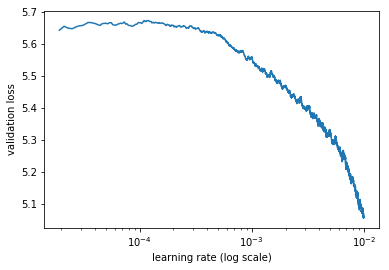

In [52]:
learner.sched.plot()

In [53]:
lrs = np.array([1e-4, *[5e-4]*6, 2e-3])
learner.unfreeze()
learner.clip = 5.
learner.fit(lrs, n_cycle=1, wds=0, use_clr=(32,4), cycle_len=5)

epoch      trn_loss   val_loss   accuracy                     
    0      4.879172   4.801402   0.212191  
    1      4.672455   4.653626   0.228902                     
    2      4.554123   4.549286   0.23968                      
    3      4.458433   4.476455   0.247213                     
    4      4.419563   4.432238   0.252095                     



[4.432238157348019, 0.2520947202894453]

In [54]:
learner.save_encoder("lm1_enc")

In [55]:
learner.save("lm1")

In [56]:
del learner

## 3-class Classifier
As in https://zhuanlan.zhihu.com/p/27198713

### Full Dataset (v1)

In [10]:
n_toks, tokens_train, tokens_val, tokens_test = joblib.load("../data/cache/rating_unigram_tokens.pkl")

In [11]:
for df in (df_train, df_val, df_test):
    df["label"] = (df["rating"] >= 3) * 1
    df.loc[df.rating == 3, "label"] = 1
    df.loc[df.rating > 3, "label"] = 2

In [12]:
df_train.label.value_counts()

2    240094
1    184124
0    104406
Name: label, dtype: int64

In [13]:
bs = 64
trn_ds = TextDataset(tokens_train, df_train.label.values, max_seq_len=100)
val_ds = TextDataset(tokens_val, df_val.label.values, max_seq_len=100)
trn_samp = SortishSampler(tokens_train, key=lambda x: len(tokens_train[x]), bs=bs//2)
val_samp = SortSampler(tokens_val, key=lambda x: len(tokens_val[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=False, num_workers=1, pad_idx=2, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=False, num_workers=1, pad_idx=2, sampler=val_samp)
model_data = ModelData(path, trn_dl, val_dl)

In [14]:
model= get_transformer_classifier(
    n_tok=n_toks, 
    emb_sz=EMB_DIM, 
    n_head=12, 
    n_layer=6, 
    n_ctx=100,
    clf_layers=[EMB_DIM, 100, 3],
    pad_token=2,
    embd_pdrop=0.1,
    attn_pdrop=0.1,
    resid_pdrop=0.1,
    clf_pdrop=[0.5, 0.2],
    afn="gelu"
)    

In [15]:
learn = TransformerLearner(
    model_data, 
    TransformerTextModel(to_gpu(model)), 
    opt_fn=partial(torch.optim.Adam, betas=(0.8, 0.99)))
learn.clip=2.
learn.metrics = [accuracy]
learn.load_encoder('lm1_enc')

In [16]:
lrs = np.array([1e-3 / 2 ** (7 - i) for i in range(8)])
learn.freeze_to(-1)
learn.fit(lrs, 1, wds=0, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                        
    0      0.975933   0.933682   0.538863  



[0.9336821136666851, 0.5388631617179697]

 81%|████████  | 13390/16520 [15:56<03:43, 14.00it/s, loss=3.22]

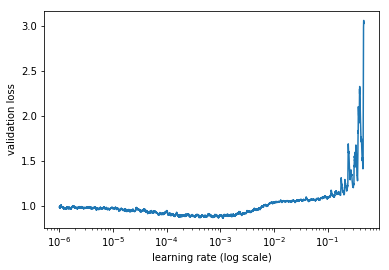

In [17]:
lrs = np.array([1e-3 / 2 ** (7 - i) for i in range(8)])
learn.unfreeze()
learn.lr_find(lrs/1000)
learn.sched.plot()

In [18]:
learn.unfreeze()
learn.fit(lrs, 1, wds=0, cycle_len=10, use_clr=(32,10))

epoch      trn_loss   val_loss   accuracy                        
    0      0.816995   0.831963   0.614671  
    1      0.793568   0.784209   0.63891                         
    2      0.798699   0.772591   0.641293                        
    3      0.755744   0.769108   0.648137                        
    4      0.759209   0.764101   0.649647                        
    5      0.72702    0.770679   0.651083                        
    6      0.73225    0.775643   0.652082                        
    7      0.706188   0.776128   0.651565                        
    8      0.689349   0.798562   0.6532                          
    9      0.67012    0.808373   0.652348                        


[0.8083732705896496, 0.6523483610278762]

In [21]:
learn.save("clas_full")

#### Evaluate

In [22]:
learn.load("clas_full")
learn.model.reset()

In [23]:
learn.model.eval()
preds, ys = [], []
for x, y in tqdm_notebook(val_dl):
    preds.append(np.argmax(learn.model(x).cpu().data.numpy(), axis=1))
    ys.append(y.cpu().numpy())

In [24]:
preds = np.concatenate(preds)
ys = np.concatenate(ys)
preds.shape, ys.shape

((176208,), (176208,))

In [25]:
pd.Series(ys).value_counts()

2    80031
1    61374
0    34803
dtype: int64

In [26]:
pd.Series(preds).value_counts()

2    85925
1    62542
0    27741
dtype: int64

In [27]:
np.sum(ys==preds) / ys.shape[0]

0.6523483610278762

In [28]:
np.where(ys==0)

(array([    12,     15,     18, ..., 176198, 176202, 176207]),)

In [29]:
tokens_val[176196]

array([   1,  296,    4, 5142,    3, 1195,   13,   20,   16,    5, 3497,  326,    8,    3,   15,   82,  179])

In [30]:
sp.DecodeIds(tokens_val[176196].tolist()), df_val["comment"].iloc[176196]

('如此 的 欺骗 , 或许 我 也 就 释然 了 , 有 什么 呢', '如此 的 欺骗 ， 或许 我 也 就 释然 了 ， 有 什么 呢')

In [45]:
def get_prediction(texts):
    input_tensor = T(np.array([1] + sp.EncodeAsIds(texts))).unsqueeze(0)[:, :100]
    return learn.model(input_tensor)[0].data.cpu().numpy()

In [35]:
get_prediction("看 了 快 一半 了 才 发现 是 mini 的 广告")

array([-0.93497,  1.06628, -1.21033], dtype=float32)

In [36]:
get_prediction("妈蛋 ， 简直 太 好看 了 。 最后 的 DJ battle 部分 ， 兴奋 的 我 ， 简直 想 从 座位 上 站 起来 一起 扭")

array([-2.82742, -1.15121,  3.01437], dtype=float32)

In [37]:
get_prediction("说 实话 我 没 怎么 认真 看 ， 电影院 里 的 熊 孩子 太 闹腾 了 ， 前面 的 小奶娃 还 时不时 站 "
               "在 老爸 腿上 蹦迪 ， 观影 体验 极差 ， 不过 小朋友 应该 挺 喜欢 的")

array([-0.88522,  0.78842, -0.64733], dtype=float32)

In [38]:
get_prediction("这 电影 太 好笑 了 ， 说好 的 高科技 人才 研制 的 产品 永远 在 关键 时候 失灵 "
               "； 特地 飞 到 泰国 请来 救援 人才 ， 大家 研究 出 的 方法 每次 都是 先 给 鲨鱼 "
               "当 诱饵 … … 显然 这样 的 对战 坚持不了 多久 ， 只能 赶紧 让 鲨鱼 输 了 。")

array([-2.91495, -1.00263,  3.00592], dtype=float32)

In [39]:
get_prediction("太 接地气 了 ， 在 三亚 煮饺子 式 的 景区 海域 ， 冒出来 一条 大 鲨鱼 "
               "… … 爽点 也 很 密集 ， 郭达森 与 李冰冰 的 CP 感 不错 ， 编剧 果然 是 "
               "老外 ， 中文 台词 有点 尬 。")

array([-2.69502,  0.99664,  0.95434], dtype=float32)

In [40]:
get_prediction("李冰冰 的 脸 真的 很 紧绷 ， 比 鲨鱼 的 脸 还 绷 。")

array([-0.37585,  0.40224, -0.51943], dtype=float32)

In [41]:
get_prediction("太 难 了 。 。 。")

array([ 1.09429, -0.15851, -0.8539 ], dtype=float32)

In [42]:
get_prediction("把 我 基神 写成 智障 ， 辣鸡 mcu")

array([ 1.50037, -0.74921, -0.08398], dtype=float32)

In [46]:
get_prediction("鲨鱼 部分 还是 不错 的 ， 尤其 是 中段 第一次 出海 捕鲨 非常 刺激 ， 其后 急速 下滑 ， "
               "三亚 那 部分 拍得 是什么 鬼 。 。 。 爆米花 片 可以 适度 的 蠢 ， 但 人类 反派 炸鲨 "
               "和 直升机 相撞 部分 简直 蠢得 太过份 了 吧 ？ 另外 充满 硬 加戏 视感 的 尴尬 感情戏 "
               "把 节奏 也 拖垮 了 ， 明明 可以 更 出色 ， 却 很遗憾 地 止步 在 马马虎虎 的 水平 。 6 / 10")

array([ 0.00563,  1.18905, -2.86299], dtype=float32)

In [47]:
get_prediction("老冰冰 真的 很努力 ！ 为 老冰冰 实现 了 她 的 好莱坞 女主梦 鼓掌 . . .")

array([-3.23207,  0.19572,  2.10121], dtype=float32)

In [48]:
get_prediction("结局 简直 丧 出 天际 ！ 灭霸 竟然 有 内心戏 ！ 全程 下来 美队 "
               "和 钢铁侠 也 没 见上 一面 ， 我 还 以为 在 世界 末日 前 必然 "
               "要 重修 旧好 了 ！ ")

array([ 0.64459,  0.7838 , -2.75728], dtype=float32)

In [49]:
get_prediction("太 烂 了 ， 难看 至极 。")

array([ 3.03603, -0.7962 , -2.12671], dtype=float32)

In [50]:
get_prediction("看完 之后 很 生气 ！ 剧情 太差 了")

array([ 1.26615,  0.62203, -3.12839], dtype=float32)

In [51]:
get_prediction("关键点 都 好傻 ， 我 知道 你 要拍 续集 ， "
               "我 知道 未来 可以 被 重写 ， 但 那 一拳 真的 有点 傻 。")

array([ 1.49094,  0.3343 , -2.50171], dtype=float32)

In [52]:
get_prediction("好了 可以 了 。 再也 不看 Marvel 了 。 我 努力 过 了 。 实在 是 。 。 啥呀 这是 。 🙄️")

array([-3.35765, -0.12141,  2.46626], dtype=float32)

In [53]:
get_prediction("还 我 电影票 14 元")

array([ 2.26484, -0.33687, -1.69309], dtype=float32)

Confusion matrix, without normalization
[[19016 11708  4079]
 [ 6643 34409 20322]
 [ 2082 16425 61524]]


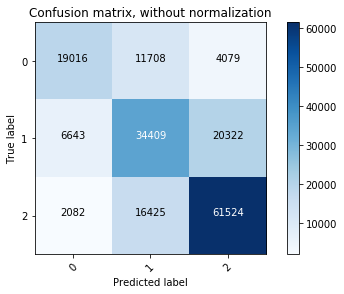

In [54]:
cnf_matrix = confusion_matrix(ys, preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(
    cnf_matrix, classes=[0, 1, 2],
    title='Confusion matrix, without normalization')

Normalized confusion matrix
[[0.55 0.34 0.12]
 [0.11 0.56 0.33]
 [0.03 0.21 0.77]]


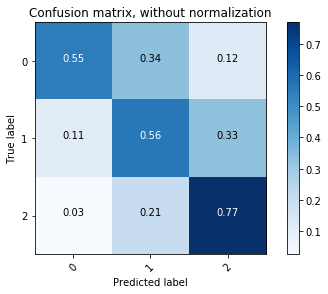

In [55]:
plot_confusion_matrix(
    cnf_matrix, classes=[0, 1, 2], normalize=True,
    title='Confusion matrix, without normalization')

In [56]:
precision, recall, fscore, support = precision_recall_fscore_support(ys, preds)
for i in range(3):
    print(f"Class {i}: P {precision[i]*100:.0f}%, R {recall[i]*100:.0f}%, FS {fscore[i]:.2f}, Support: {support[i]}")

Class 0: P 69%, R 55%, FS 0.61, Support: 34803
Class 1: P 55%, R 56%, FS 0.56, Support: 61374
Class 2: P 72%, R 77%, FS 0.74, Support: 80031


In [60]:
test_ds = TextDataset(tokens_test, df_test.label.values, max_seq_len=100)
test_samp = SortSampler(tokens_test, key=lambda x: len(tokens_test[x]))
test_dl = DataLoader(test_ds, bs, transpose=False, num_workers=1, pad_idx=0, sampler=test_samp)

In [61]:
learn.model.eval()
preds, ys = [], []
for x, y in tqdm_notebook(test_dl):
    preds.append(np.argmax(learn.model(x).cpu().data.numpy(), axis=1))
    ys.append(y.cpu().numpy())

In [62]:
preds = np.concatenate(preds)
ys = np.concatenate(ys)
preds.shape, ys.shape

((176209,), (176209,))

In [63]:
np.sum(ys==preds) / ys.shape[0]

0.6509769648542356

Confusion matrix, without normalization
[[18776 11889  4137]
 [ 6787 34280 20308]
 [ 2065 16315 61652]]


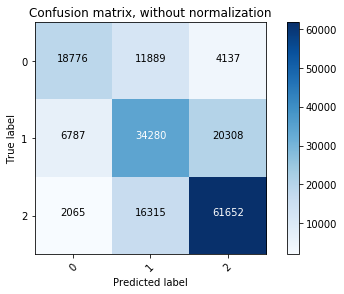

In [64]:
cnf_matrix = confusion_matrix(ys, preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(
    cnf_matrix, classes=[0, 1, 2],
    title='Confusion matrix, without normalization')

Normalized confusion matrix
[[0.54 0.34 0.12]
 [0.11 0.56 0.33]
 [0.03 0.2  0.77]]


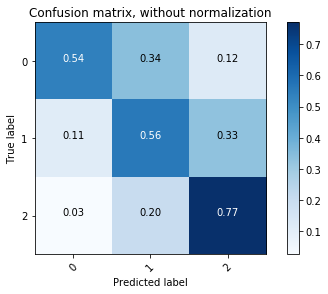

In [65]:
plot_confusion_matrix(
    cnf_matrix, classes=[0, 1, 2], normalize=True,
    title='Confusion matrix, without normalization')

In [66]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(ys, preds)
for i in range(3):
    print(f"Class {i}: P {precision[i]*100:.0f}%, R {recall[i]*100:.0f}%, FS {fscore[i]:.2f}, Support: {support[i]}")

Class 0: P 68%, R 54%, FS 0.60, Support: 34802
Class 1: P 55%, R 56%, FS 0.55, Support: 61375
Class 2: P 72%, R 77%, FS 0.74, Support: 80032


### Smaller Dataset 

In [10]:
n_toks, tokens_train, tokens_val, tokens_test = joblib.load("../data/cache/rating_unigram_tokens.pkl")

In [11]:
for df in (df_train, df_val, df_test):
    df["label"] = (df["rating"] >= 3) * 1
    df.loc[df.rating == 3, "label"] = 1
    df.loc[df.rating > 3, "label"] = 2

In [12]:
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)

In [13]:
df_train_small = pd.concat([
    df_train[df_train.label==0].sample(15000),
    df_train[df_train.label==1].sample(15000),
    df_train[df_train.label==2].sample(15000)
], axis=0)
df_val_small = pd.concat([
    df_val[df_val.label==0].sample(5000),
    df_val[df_val.label==1].sample(5000),
    df_val[df_val.label==2].sample(5000)
], axis=0)

In [14]:
np.array(df_train_small.index)

array([116109, 242673, 456939, ..., 292281, 226809, 508226])

In [15]:
bs = 64
tokens_train_small = np.array(tokens_train)[np.array(df_train_small.index)]
tokens_val_small = np.array(tokens_val)[np.array(df_val_small.index)]
trn_ds = TextDataset(tokens_train_small, df_train_small.label.values, max_seq_len=100)
val_ds = TextDataset(tokens_val_small, df_val_small.label.values, max_seq_len=100)
trn_samp = SortishSampler(tokens_train_small, key=lambda x: len(tokens_train_small[x]), bs=bs//2)
val_samp = SortSampler(tokens_val_small, key=lambda x: len(tokens_val_small[x]))
# trn_dl = FixedLengthDataLoader(
#     trn_ds, batch_size=bs//2, seq_length=100, transpose=False, num_workers=1, pad_idx=2, sampler=trn_samp)
# val_dl = FixedLengthDataLoader(
#     val_ds, batch_size=bs, seq_length=100, transpose=False, num_workers=1, pad_idx=2, sampler=val_samp)
trn_dl = DataLoader(trn_ds, batch_size=bs//2, transpose=False, num_workers=1, pad_idx=2, sampler=trn_samp)
val_dl = DataLoader(val_ds, batch_size=bs, transpose=False, num_workers=1, pad_idx=2, sampler=val_samp)
model_data = ModelData(path, trn_dl, val_dl)

In [16]:
model= get_transformer_classifier(
    n_tok=n_toks, 
    emb_sz=EMB_DIM, 
    n_head=12, 
    n_layer=6, 
    n_ctx=100,
    clf_layers=[EMB_DIM, 100, 3],
    pad_token=2,
    embd_pdrop=0.1,
    attn_pdrop=0.2,
    resid_pdrop=0.2,
    clf_pdrop=[0.5, 0.2],
    afn="gelu"
)

In [17]:
learn = TransformerLearner(
    model_data, 
    TransformerTextModel(to_gpu(model)), 
    opt_fn=partial(torch.optim.Adam, betas=(0.8, 0.99)))
learn.clip=25
learn.metrics = [accuracy]
learn.load_encoder('lm1_enc')

In [18]:
learn.freeze_to(-1)
lrs = np.array([2e-4, *[5e-4]*6, 1e-3])
learn.fit(lrs, 1, wds=1e-5, cycle_len=1, use_clr=(8,3), use_wd_sched=True)

epoch      trn_loss   val_loss   accuracy                     
    0      1.076279   1.014316   0.4822    



[1.0143162530899048, 0.4822000000158946]

 79%|███████▉  | 1111/1407 [01:27<00:23, 12.67it/s, loss=3.87]

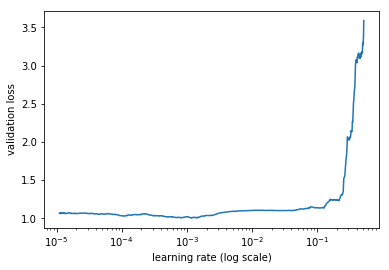

In [21]:
lrs = np.array([1e-4, *[1e-4]*6, 2e-4])
learn.unfreeze()
learn.lr_find(lrs/100)
learn.sched.plot()

In [22]:
lrs = np.array([1e-4, *[1e-4]*6,2e-4])
learn.unfreeze()
learn.fit(lrs, 1, wds=1e-5, cycle_len=8, use_clr=(16,4), use_wd_sched=True)

epoch      trn_loss   val_loss   accuracy                      
    0      0.954783   0.91678    0.555333  
    1      0.905701   0.916583   0.562533                      
    2      0.88402    0.883497   0.586533                      
    3      0.843824   0.883794   0.589                         
    4      0.811115   0.879617   0.592467                      
    5      0.817176   0.87323    0.597933                      
    6      0.785547   0.888924   0.593533                      
    7      0.758039   0.907905   0.597333                      


[0.9079052782694499, 0.5973333333651225]

In [23]:
learn.save("clas_small_full")

In [24]:
learn.model.eval()
preds, ys = [], []
for x, y in val_dl:
    preds.append(np.argmax(learn.model(x).cpu().data.numpy(), axis=1))
    ys.append(y.cpu().numpy())

In [25]:
preds = np.concatenate(preds)
ys = np.concatenate(ys)
preds.shape, ys.shape

((15000,), (15000,))

In [26]:
np.sum(preds==ys) / preds.shape[0]

0.5973333333333334

Normalized confusion matrix
[[0.68 0.22 0.1 ]
 [0.25 0.44 0.31]
 [0.1  0.23 0.68]]


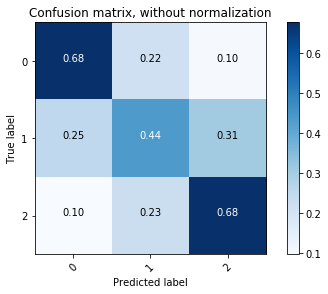

In [27]:
cnf_matrix = confusion_matrix(ys, preds)
np.set_printoptions(precision=2)
plot_confusion_matrix(
    cnf_matrix, classes=[0, 1, 2], normalize=True,
    title='Confusion matrix, without normalization')

In [30]:
test_ds = TextDataset(tokens_test, df_test.label.values, max_seq_len=100)
test_samp = SortSampler(tokens_test, key=lambda x: len(tokens_test[x]))
test_dl = DataLoader(test_ds, bs, transpose=False, num_workers=1, pad_idx=2, sampler=test_samp)

In [31]:
learn.model.eval()
preds, ys = [], []
for x, y in tqdm_notebook(test_dl):
    preds.append(np.argmax(learn.model(x).cpu().data.numpy(), axis=1))
    ys.append(y.cpu().numpy())

In [32]:
preds = np.concatenate(preds)
ys = np.concatenate(ys)
print(preds.shape, ys.shape)
np.sum(preds==ys) / preds.shape[0]

(176209,) (176209,)


0.5993223955643582

Normalized confusion matrix
[[0.68 0.21 0.11]
 [0.25 0.45 0.29]
 [0.1  0.23 0.68]]


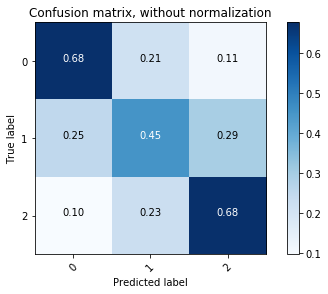

In [33]:
cnf_matrix = confusion_matrix(ys, preds)
np.set_printoptions(precision=2)
plot_confusion_matrix(
    cnf_matrix, classes=[0, 1, 2], normalize=True,
    title='Confusion matrix, without normalization')

In [34]:
precision, recall, fscore, support = precision_recall_fscore_support(ys, preds)
for i in range(3):
    print(f"Class {i}: P {precision[i]*100:.0f}%, R {recall[i]*100:.0f}%, FS {fscore[i]:.2f}, Support: {support[i]}")

Class 0: P 50%, R 68%, FS 0.58, Support: 34802
Class 1: P 52%, R 45%, FS 0.49, Support: 61375
Class 2: P 71%, R 68%, FS 0.69, Support: 80032


## Regressor

In [57]:
n_toks, tokens_train, tokens_val, tokens_test = joblib.load("../data/cache/rating_unigram_tokens.pkl")

In [36]:
bs = 128
trn_ds = TextDataset(tokens_train, df_train.rating.values.astype("float32"), max_seq_len=100)
val_ds = TextDataset(tokens_val, df_val.rating.values.astype("float32"), max_seq_len=100)
trn_samp = SortishSampler(tokens_train, key=lambda x: len(tokens_train[x]), bs=bs//2)
val_samp = SortSampler(tokens_val, key=lambda x: len(tokens_val[x]))
# trn_dl = FixedLengthDataLoader(trn_ds, seq_length=100, batch_size=bs//2, transpose=False, num_workers=1, pad_idx=2, sampler=trn_samp)
# val_dl = FixedLengthDataLoader(val_ds, seq_length=100, batch_size=bs, transpose=False, num_workers=1, pad_idx=2, sampler=val_samp)
trn_dl = DataLoader(trn_ds, batch_size=bs//2, transpose=False, num_workers=1, pad_idx=2, sampler=trn_samp)
val_dl = DataLoader(val_ds, batch_size=bs, transpose=False, num_workers=1, pad_idx=2, sampler=val_samp)
model_data = ModelData(path, trn_dl, val_dl)

In [37]:
tmp = next(iter(trn_dl))
tmp[0].size()

torch.Size([64, 100])

In [38]:
tmp[0][2, :]

tensor([   1,  199,   22,   16,   99,  879,    4,  826,    5,    0, 2366,    6,
        2974,    3, 1098, 1724,    9,   39,  801, 3143, 5290,    3, 1038,   20,
        2046,    9, 1325,    4,   10,  239, 1008, 2752,    3, 1177,  103,   19,
         343, 1488,    3,  184, 2342,    8,   88,    4, 6632, 2591, 3222,  114,
         794, 2008,  669,    4, 1346, 3917,    6,  177,   24, 1074,  162,  373,
           3,   57, 2029,   22, 3706, 6853,    5,    0,    4, 5640, 1632, 3617,
        2297,    5, 5207,  875,   81,  139,    5, 3904, 1892, 4343, 7296, 5241,
           3,  904,  402, 1763,   88,   64, 1567,   95, 2664, 2512,   20,   85,
           5, 4799, 4641,    5], device='cuda:0')

In [58]:
class TransformerRegLearner(TransformerLearner):
    def __init__(self, data, models, **kwargs):
        super().__init__(data, models, **kwargs)

    def _get_crit(self, data): return lambda x, y: F.mse_loss(x[:, 0], y)

In [59]:
model= get_transformer_classifier(
    n_tok=n_toks, 
    emb_sz=EMB_DIM, 
    n_head=12, 
    n_layer=6, 
    n_ctx=100,
    clf_layers=[EMB_DIM, 100, 1],
    pad_token=2,
    embd_pdrop=0.1,
    attn_pdrop=0.1,
    resid_pdrop=0.1,
    clf_pdrop=[0.5, 0.2],
    afn="gelu"
)    

In [60]:
learn = TransformerRegLearner(
    model_data, 
    TransformerTextModel(to_gpu(model)), 
    opt_fn=partial(torch.optim.Adam, betas=(0.8, 0.99)))
learn.clip=2.
learn.load_encoder('lm1_enc')

In [61]:
learn.model[1]

MLP(
  (layers): ModuleList(
    (0): LinearBlock(
      (lin): Linear(in_features=480, out_features=100, bias=True)
      (drop): Dropout(p=0.5)
      (ln): LayerNorm(torch.Size([480]), eps=1e-05, elementwise_affine=True)
    )
    (1): LinearBlock(
      (lin): Linear(in_features=100, out_features=1, bias=True)
      (drop): Dropout(p=0.2)
      (ln): LayerNorm(torch.Size([100]), eps=1e-05, elementwise_affine=True)
    )
  )
)

In [62]:
lrs = np.array([5e-5, *[1e-4]*6, 1e-3])
learn.freeze_to(-1)
%time learn.fit(lrs, 1, wds=0, cycle_len=1, use_clr=(8,3))
learn.save('reg_0')

epoch      trn_loss   val_loss                                
    0      1.091365   0.946824  
CPU times: user 4min 41s, sys: 3min 16s, total: 7min 57s
Wall time: 7min 54s


 80%|███████▉  | 6570/8260 [14:51<03:49,  7.37it/s, loss=2.41] 

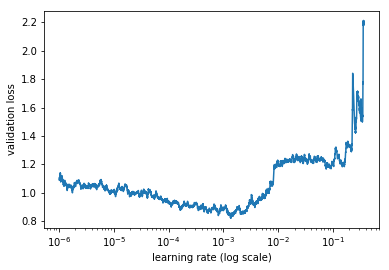

In [47]:
lrs = np.array([5e-5, *[1e-4]*6, 1e-3])
learn.unfreeze()
learn.lr_find(lrs/1000)
learn.sched.plot()

In [64]:
lrs = np.array([1e-4, *[5e-4 / 2 ** (6 - i) for i in range(6)], 1e-3])
learn.freeze_to(-3)
%time learn.fit(lrs, 1, wds=1e-5, cycle_len=2, use_clr=(32,4), use_wd_sched=True)

epoch      trn_loss   val_loss                                 
    0      0.869585   0.814217  
    1      0.863255   0.745996                                 
CPU times: user 13min 3s, sys: 9min 5s, total: 22min 9s
Wall time: 22min 2s


[0.7459960235493347]

In [65]:
lrs = np.array([1e-4, *[5e-4 / 2 ** (6 - i) for i in range(6)], 1e-3])
learn.freeze_to(-5)
%time learn.fit(lrs, 1, wds=1e-5, cycle_len=2, use_clr=(32,4), use_wd_sched=True)

epoch      trn_loss   val_loss                                 
    0      0.748412   0.713915  
    1      0.686241   0.687606                                 
CPU times: user 18min 43s, sys: 13min 26s, total: 32min 10s
Wall time: 32min 2s


[0.6876059699954794]

In [66]:
learn.save("tmp")

In [67]:
learn.unfreeze()
lrs = np.array([1e-4, *[5e-4 / 2 ** (6 - i) for i in range(6)], 1e-3])
%time learn.fit(lrs, 1, wds=1e-5, cycle_len=2, use_clr=(32,4), use_wd_sched=True)
learn.save('reg_full')

epoch      trn_loss   val_loss                                 
    0      0.694939   0.689135  
    1      0.658806   0.667701                                 
CPU times: user 26min 20s, sys: 18min 39s, total: 44min 59s
Wall time: 44min 58s


In [68]:
# Export Model
torch.save(learn.model, path / "sentiment_model.pth")

### Evaluation

In [69]:
def get_preds(data_loader):
    learn.model.eval()       
    preds, ys = [], []
    for x, y in tqdm_notebook(data_loader):   
        with torch.set_grad_enabled(False):
            preds.append(learn.model(x).cpu().data.numpy()[:, 0])
            ys.append(y.cpu().numpy())
    preds = np.concatenate(preds)
    ys = np.concatenate(ys)
    return ys, preds

In [70]:
ys, preds = get_preds(val_dl)
print("(Validation set):", preds.shape, ys.shape)
np.sum(np.square(preds - ys)) / preds.shape[0]

(Validation set): (176208,) (176208,)


0.6677007783415055

In [71]:
pd.Series(preds).describe()

count    176208.000000
mean          3.363096
std           0.814887
min           0.832348
25%           2.859134
50%           3.461971
75%           3.988681
max           4.798726
dtype: float64

In [ ]:
preds = np.clip(preds, 1, 5)
np.sum(np.square(preds - ys)) / preds.shape[0]

In [74]:
test_ds = TextDataset(tokens_test, df_test.rating.values, max_seq_len=100)
test_samp = SortSampler(tokens_test, key=lambda x: len(tokens_test[x]))
test_dl = DataLoader(test_ds, bs, transpose=False, num_workers=1, pad_idx=2, sampler=test_samp)

In [75]:
ys, preds = get_preds(test_dl)
print("(Test set):", preds.shape, ys.shape)
np.sum(np.square(preds - ys)) / preds.shape[0]

(Test set): (176209,) (176209,)


0.6723806315357022

In [76]:
preds = np.clip(preds, 1, 5)
np.sum(np.square(preds - ys)) / preds.shape[0]

0.6723734144838666

In [ ]:
pd.Series(ys).describe()

In [90]:
# Save predictions
df_test.loc[df_test.iloc[list(iter(test_samp))].index, "preds"] = preds
# df_test.to_csv(path / "df_test.csv.gz", index=False, compression="gzip")
df_test.head()

,comment,rating,label,preds
258461,无话可说 .,3,1,2.493271
118491,老师 你 太 可爱,5,2,4.157641
44768,说 了 好多 话 ， 可惜 都 是 陈词滥调 、 无 凭 无据 。,2,0,2.707678
34630,普巴 家用 的 电脑 是 苹果 。,3,1,3.348979
382761,这 才 是 一 部 看 完 之后 观众 讲 不 清道 不 明 的 电影 ， 主线 不 明了 ...,4,2,3.533488


In [91]:
df_test.sample(20)

,comment,rating,label,preds
797185,终于 找到 了 ！ 高中 时 和 一 帮 同学 一起 看 得 好 起劲 ， 膝盖 向 后 弯...,3,1,4.149887
330580,的确 很 勉强 了,3,1,2.716822
582044,昆汀 童鞋 你 怎 马 回归 故事 流 了 。 。 。 白眉一 出场 顿时 就 欢乐 了 音...,3,1,3.660117
567093,这个 很 赞 。 整部 电影 的 配乐 非常 有趣 ， 味道 浓烈 。 我 一 忽儿 看到 ...,5,2,4.563919
254892,珍爱 生命 ， 远离 烂片 ！ ！ ！ ！ 谁 TMD 敢 说 这 是 个 恐怖片 ？ ？ ...,1,0,1.531836
475299,非常 沉 得 住 气 的 一 部 片子 ， 前面 近 两 个 小时 都 是 在 为 最后 的...,4,2,3.667084
826166,几 个 老套 的 场景 设计 。,2,0,2.754994
849581,说 英文 的 阿童木 。 。 。 。 。,3,1,3.018945
578462,比不上 仁义 的 墓场 ~ 7.7,4,2,3.175455
685760,还 行 ， 一般 科幻片 吧 ， 题材 好看 ， 喜欢 这 类 的 科幻片,3,1,3.385180


In [78]:
np.sum(np.square(df_test.rating.values - df_test.preds.values)) / preds.shape[0]

AttributeError: 'DataFrame' object has no attribute 'preds'

In [79]:
preds_class = np.round(preds)

Confusion matrix, without normalization
[[ 3135  4756  2641   913    77]
 [ 1276  9376  9981  2590    57]
 [  268  6840 33690 20072   505]
 [   51  1170 14405 35827  3196]
 [   45   415  3105 16293  5525]]


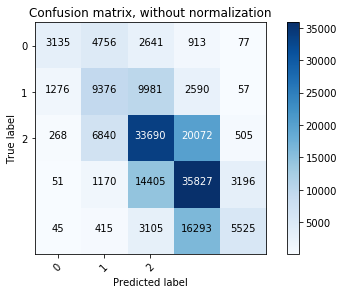

In [80]:
cnf_matrix = confusion_matrix(ys, preds_class)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(
    cnf_matrix, classes=[0, 1, 2],
    title='Confusion matrix, without normalization')

In [81]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(ys, preds_class)
for i in range(5):
    print(f"Class {i}: P {precision[i]*100:.0f}%, R {recall[i]*100:.0f}%, FS {fscore[i]:.2f}, Support: {support[i]}")

Class 0: P 66%, R 27%, FS 0.38, Support: 11522
Class 1: P 42%, R 40%, FS 0.41, Support: 23280
Class 2: P 53%, R 55%, FS 0.54, Support: 61375
Class 3: P 47%, R 66%, FS 0.55, Support: 54649
Class 4: P 59%, R 22%, FS 0.32, Support: 25383


In [82]:
def get_prediction(texts):
    input_tensor = T(np.array([1] + sp.EncodeAsIds(texts))).unsqueeze(0)
    return learn.model(input_tensor).data.cpu().numpy()[0, 0]

In [83]:
get_prediction("看 了 快 一半 了 才 发现 是 mini 的 广告")

2.36404

In [84]:
get_prediction("妈蛋 ， 简直 太 好看 了 。 最后 的 DJ battle 部分 ， 兴奋 的 我 ， 简直 想 从 座位 上 站 起来 一起 扭")

4.69897

In [85]:
get_prediction("关键点 都 好傻 ， 我 知道 你 要拍 续集 ， "
               "我 知道 未来 可以 被 重写 ， 但 那 一拳 真的 有点 傻 。")

2.5457776

In [86]:
get_prediction("李冰冰 的 脸 真的 很 紧绷 ， 比 鲨鱼 的 脸 还 绷 。")

2.9808483

In [87]:
get_prediction("太 烂 了 ， 难看 至极 。")

1.2158102

In [88]:
get_prediction("看完 之后 很 生气 ！ 剧情 太差 了")

2.4479275

In [89]:
get_prediction("好了 可以 了 。 再也 不看 Marvel 了 。 我 努力 过 了 。 实在 是 。 。 啥呀 这是 。 🙄️")

3.0634825

In [90]:
get_prediction("还 我 电影票 14 元")

2.0054574